<a href="https://colab.research.google.com/github/0xFAB10/Avalia-o-Projetista-de-Sistemas-Embarcados-de-Machine-Learning/blob/main/Respostas_PSEML___Fabio_Araujo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Questão 01
<p>Processamento Digital de Imagens (20 escores)
<br>Implemente um código Python utilizando OpenCV para realizar a contagem de objetos
em uma imagem.
<br>O código deve:
<br>• Ler uma imagem de entrada;
<br>• Aplicar conversão para escala de cinza;
<br>• Realizar suavização com filtro Gaussiano;
<br>• Binarizar a imagem (thresholding);
<br>• Utilizar contornos para identificar e contar os objetos;
<br>• Exibir a imagem com a contagem anotada.

In [1]:
# Imports

import cv2
from google.colab.patches import cv2_imshow

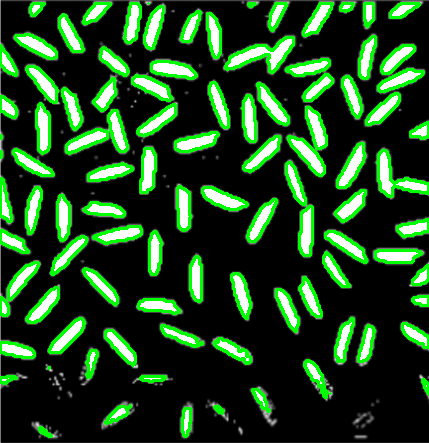

Número de objetos encontrados: 100


In [2]:
# LÊ imagem
img = cv2.imread("graos.png")
# Aplica escala de cinza
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Aplica fintro Gaussiano
blur_img = cv2.GaussianBlur(gray_img, (3, 3), 0)
# Aplica binarização
_,bin_img = cv2.threshold(blur_img, 200, 255,cv2.THRESH_BINARY)
# Encontra contornos
contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Desenha contornos
cv2.drawContours(img, contours, -1, (0,255,0),2)


cv2_imshow(img)
print(f"Número de objetos encontrados: {len(contours)}")

<h2>Questão 02
<p>Contagem de Pessoas com YOLOv8 (30 escores)
<br>Dada a imagem abaixo, implemente um código Python utilizando o modelo pré-treinado YOLOv8 para detectar e contar quantas pessoas foram identificadas.
<br>• Instale o pacote ultralytics:
<br>• Carregue o modelo YOLOv8;
<br>• Faça a inferência utilizando o método model.predict();
<br>• Conte quantas detecções possuem o rótulo “person”.

In [3]:
# Instala ultralytics
!pip -q install ultralytics

In [4]:
# Imports

import cv2

from ultralytics import YOLO
from google.colab.patches import cv2_imshow

In [5]:
# Baixa modelo
model = YOLO('yolov8n.pt')

In [6]:
# Identifica a chave do rótulo person
label = [k for k,v in model.names.items() if v == 'person']
# Importa imagem
img = cv2.imread('person.png')
# Gera inferência
results = model.predict(img, classes=label, conf=0.4)
# Conta numero de resultados
person_count = len(results[0].boxes)


0: 512x640 7 persons, 325.0ms
Speed: 8.0ms preprocess, 325.0ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 640)


Detecção 1
Confiança: 0.9250543117523193
Classe: person


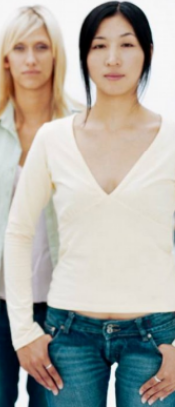

------------------------------
Detecção 2
Confiança: 0.916928768157959
Classe: person


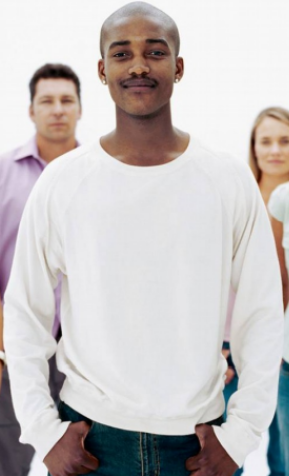

------------------------------
Detecção 3
Confiança: 0.902269184589386
Classe: person


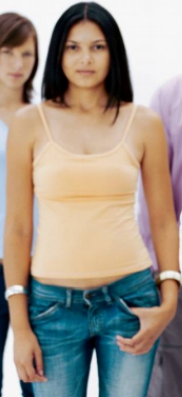

------------------------------
Detecção 4
Confiança: 0.8833939433097839
Classe: person


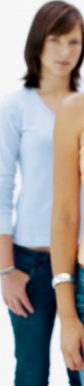

------------------------------
Detecção 5
Confiança: 0.775347888469696
Classe: person


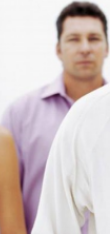

------------------------------
Detecção 6
Confiança: 0.6724937558174133
Classe: person


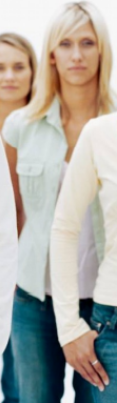

------------------------------
Detecção 7
Confiança: 0.4343963861465454
Classe: person


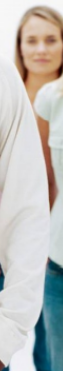

------------------------------


In [7]:
# Exibindo detecções

for i, box in enumerate(results[0].boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # coordenadas da bounding box
    conf = box.conf[0]                      # confiança
    cls = box.cls[0]                        # classe
    crop = img[y1:y2, x1:x2]               # recorte da imagem

    print(f"Detecção {i+1}")
    print("Confiança:", float(conf))
    print("Classe:", model.names[int(cls)])

    cv2_imshow(crop)
    print("-" * 30)

In [8]:
# Imprime resultado
print (f"Pessoas detectadas: {person_count}")

Pessoas detectadas: 7


<h2>Questão 03
<p>Classificador de Tipos de Carros (50 escores)
<br>Treine um classificador de tipos de carros utilizando Deep Learning.
<br>• Use o <a href='https://www.kaggle.com/datasets/vikrampunia/bmw10-release?resource=download'> BMW-10 dataset</a>;
<br>• Filtrar apenas classes 3, 4, 5 e adote algum procedimento para as demais classes, criando uma classe "Outros";
<br>• Dividir dados em treino, validação e teste.
<br>• Treine um modelo de rede neural, mostre a matriz de confusão e métricas de desempenho advindas dela;
<br>• É importante que o candidato exiba os resultados de forma gráfica, de maneira a possibilitar discussão no momento da entrevista técnica;

In [9]:
# Descompacta dataset
!unzip -q bmw10_release.tgz.zip -d bmw10/
!tar -xzf bmw10/bmw10_release.tgz -C bmw10/

replace bmw10/bmw10_release.tgz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [10]:
# Imports

import os
import scipy.io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
# Abre arquivo matlab
data = scipy.io.loadmat("bmw10/bmw10_annos.mat",simplify_cells=True)

annos = data["annos"]

# Converte indexação de base um (Matlab) para base zero (Python)
train_idx = data["train_indices"] - 1
test_idx = data["test_indices"] - 1

In [12]:
# Normaliza dados das anotações

def normalize_registers(annotations, end_imgs='bmw10/bmw10_ims/', classes=[3,4,5]):
    # Seleciona classes e formatar
    registers = []
    for item in annotations:
        path = f"{end_imgs}{item['fname']}"
        classe = item["class"]

        if classe in classes:
            label = classes.index(classe)
        else:
            label = len(classes)

        bbox = (
            item["bbox_y1"],
            item["bbox_y2"],
            item["bbox_x1"],
            item["bbox_x2"],
        )

        registers.append((path, label, bbox))

    return registers

reg = normalize_registers(annos)

In [13]:
# Separa annotations entre treino e teste
train_reg = [reg[i] for i in train_idx]
test_reg = [reg[i] for i in test_idx]

# Separa validação de treino
train_reg, val_reg = train_test_split(
    train_reg,
    test_size=0.2,
    random_state=42,
    stratify=[r[1] for r in train_reg]
)

In [14]:
# Balanceia dataset


import random
from collections import defaultdict

def subsample_majority(dataset):
    # Separa por classe
    by_class = defaultdict(list)
    for item in dataset:
        by_class[item[1]].append(item)

    # Descobre tamanho médio das classes minoritárias
    sizes = [len(v) for k, v in by_class.items()]
    target_size = int(sum(sizes) / len(sizes))

    # Cria novo dataset balanceado
    balanced = []
    for label, items in by_class.items():
        if len(items) > target_size:
            items = random.sample(items, target_size)
        balanced.extend(items)

    random.shuffle(balanced)
    return balanced

train_reg = subsample_majority(train_reg)

In [15]:
# Importa imagens para dataset

IMG_SIZE = 224

def load_data(registers):
    X = []
    y = []

    for path, label, _ in registers:
        img = tf.keras.utils.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img = tf.keras.utils.img_to_array(img) / 255.0
        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)

X_train, y_train = load_data(train_reg)
X_val, y_val     = load_data(val_reg)
X_test, y_test   = load_data(test_reg)

print(X_train.shape, y_train.shape)

(112, 224, 224, 3) (112,)


In [16]:
# Balanceamento fino de classes

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))

In [17]:
# Importa modelo

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

In [18]:
# Define classificador

num_classes = len(set(y_train))

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [19]:
# Treinamento

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    class_weight=class_weights_dict
)

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.1952 - loss: 1.6406 - val_accuracy: 0.3846 - val_loss: 1.3487
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2296 - loss: 1.4783 - val_accuracy: 0.3077 - val_loss: 1.4799
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2501 - loss: 1.3755 - val_accuracy: 0.3654 - val_loss: 1.3629
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4868 - loss: 1.2311 - val_accuracy: 0.5577 - val_loss: 1.1908
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6141 - loss: 1.1558 - val_accuracy: 0.5769 - val_loss: 1.1134
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6725 - loss: 1.0791 - val_accuracy: 0.6154 - val_loss: 1.1165
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6801 - loss: 0.9897 - val_accuracy: 0.6346 - val_loss: 1.1581
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6942 - loss: 0.9521 - val_accuracy: 0.5577 - val_loss: 1.1746
Epoch 9/15


In [20]:
# Mede acurácia em dataset de teste

loss, acc = model.evaluate(X_test, y_test)
print("Acurácia teste:", acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5900 - loss: 1.0304
Acurácia teste: 0.5708661675453186


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


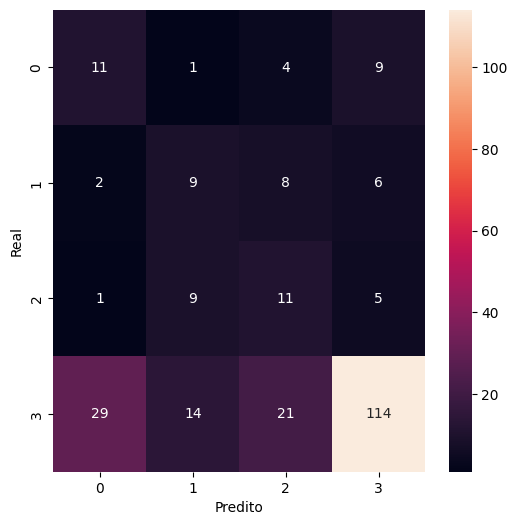

In [21]:
# Formata matriz de confusão

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

In [22]:
# Aplica finetune ao modelo treinado

base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    class_weight=class_weights_dict
)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 67s 8s/step - accuracy: 0.5204 - loss: 1.5887 - val_accuracy: 0.6731 - val_loss: 0.9672
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.5887 - loss: 1.1999 - val_accuracy: 0.6731 - val_loss: 0.9780
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.6271 - loss: 1.1084 - val_accuracy: 0.6154 - val_loss: 0.9867
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - accuracy: 0.6762 - loss: 0.9392 - val_accuracy: 0.6346 - val_loss: 0.9925
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.7156 - loss: 0.9606 - val_accuracy: 0.6538 - val_loss: 1.0020


In [23]:
# Mede acurácia do novo modelo no dataset de teste

loss, acc = model.evaluate(X_test, y_test)
print("Acurácia teste:", acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5498 - loss: 1.0575
Acurácia teste: 0.5236220359802246


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


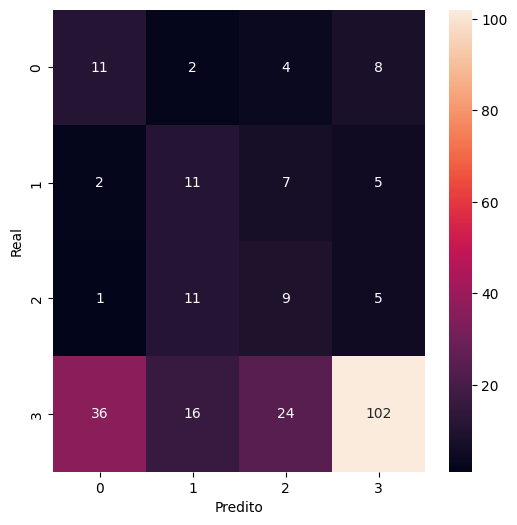

In [24]:
# Formata nova matriz de confusão

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()